# SIFT detector

SIFT stands for Scale-Invariant Feature Transform and was first presented in 2004 by D.Lowe, University of British Columbia. 

SIFT is invariance to image scale and rotation. This algorithm is patented and everyone needs to pay to use it.

It is similar to the the system used in primate visual system. 


<center><img src="https://www.researchgate.net/profile/Jasmin-Velagic/publication/328991586/figure/fig1/AS:750726502424577@1555998554376/Feature-matching-and-object-detection-using-ORB-a-BRISK-b-SIFT-c-or-SURF-d.ppm"></center>


SIFT goals : 
- Extract distinctive invariant features
- Invariance to image scale and rotation
- Robustness to affine distortion, changing in 3D viewpoint, noise



In [2]:
import cv2 as cv
from matplotlib import pyplot as plt
import math

# 💎  Steps for Extracting Interest Points

<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20200517234610/C5BBC774-8499-4561-BDF6-D8D2499773F3-1024x323.png"></center>

## 🌄1. Scale-space peak Selection

Real world objects exist only because of the scaling relationship they have with other objects. For instance, a sugar cube would be perfectly visible on a kitchen table, when when compared to the milky way, it is insignificant and inexistant. The multi-scale nature of objects is a quite common concept in Nature and the concept of “scale space” attempts at the replication of this concept on digital images.


We need to identify the most distinct and meaningful features in a given image while ignoring any noise. Additionally, we need to ensure that the features are not scale-dependent.

To reduce noise in an image, we use the Gaussian Blurring technique.

In [3]:
test_img = cv.imread('data/sift/eren.jpg',0)
blured_img = cv.GaussianBlur(test_img,(5,5),100,100)

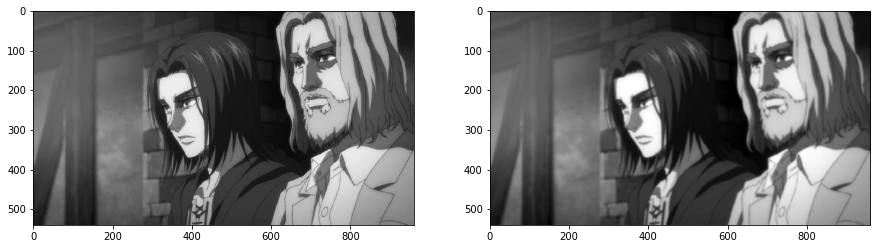

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.imshow(test_img,cmap='gray')
ax2.imshow(blured_img,cmap='gray')

As seen in the images above, the Gaussian Blurring technique successfully removed the noise from the images and has highlighted the important features of the image. Now, we need to ensure that these features must not be scale-dependent.

This means, we will be searching for these features on multiple scales by creating a scale space:
Scale space being a collection of images having different scales, generated from a single image.

Hence, these blurred images are created on multiple scales. To create a new set of images of different scales, we will take the original image and reduce the scale by half. For each new image, we will create blurred versions as seen above.


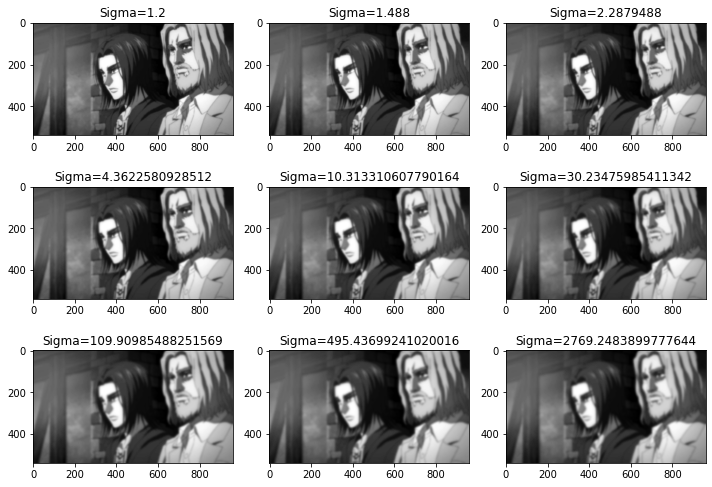

In [4]:
fig, axs = plt.subplots(3,3, figsize=(10,7))
axs = axs.ravel()
sigma = 1.2
k = 1.24
s = 1/math.sqrt(2)

for i in range(1,10):
    blured_img = cv.GaussianBlur(blured_img,(5,5),sigmaX=sigma)
    axs[i-1].imshow(blured_img, cmap='gray')
    axs[i-1].set_title('Sigma=%s' % sigma)
    sigma = sigma*k**i
    plt.tight_layout()

Gaussian Blur successfully removed the noise from the images and we have highlighted the important features of the image. Now, we need to ensure that these features must not be scale-dependent. 

This means we will be searching for these features on multiple scales, by creating a *scale space*.

Scale space is a collection of images having different scales, generated from a single image.

Hence, these blur images are created for multiple scales. To create a new set of images of different scales, we will take the original image and reduce the scale by half. For each new image, we will create blur versions as we saw above.

**Scale Space Peak Selection** depends on the Spatial Coincidence Assumption. According to this, if an edge is detected at the same location in multiple scales (indicated by zero crossings in the scale space) then we classify it as an actual edge.


The scale space of an image is a function $L(x,y,\sigma)$ that is produced from the convolution of a Gaussian kernel(Blurring) at different scales with the input image. Scale-space is separated into octaves and the number of octaves and scale depends on the size of the original image. So we generate several octaves of the original image. Each octave’s image size is half the previous one.

- 1. Blurring
$$L(x,y,\sigma) = G(x,y,\sigma)\star I(x,y) $$

$G$ is the Gaussian Blur operator and $I$ is an image. While $x$ and$y$ are the location coordinates and $\sigma$ is the “scale” parameter. Think of it as the amount of blur. Greater the value, greater the blur.

- 2. DOG(Difference of Gaussian kernel)

Now we use those blurred images to generate another set of images, the Difference of Gaussians (DoG). These DoG images are great for finding out interesting keypoints in the image. The difference of Gaussian is obtained as the difference of Gaussian blurring of an image with two different $\sigma$

<center><img src="https://docs.opencv.org/4.x/sift_dog.jpg"></center>
In fact, it's way more complicated than that. Building a scale space require choosing number of scales per octave to be able to capture most of the repeatable interest points.


<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20200518221935/F60FA5DE-EF38-4B7E-89D1-CBD432D80CC8-1024x696.png" width=450></center>

One pixel in an image is compared with its 8 neighbors as well as 9 pixels in the next scale and 9 pixels in previous scales. This way, a total of 26 checks are made. If it is a local extrema, it is a potential keypoint. It basically means that keypoint is best represented in that scale.


In 2D images, we can detect the Interest Points using the local maxima/minima in Scale Space of Laplacian of Gaussian. 

A potential SIFT interest point is determined for a given sigma value by picking the potential interest point and considering the pixels in the level above (with higher sigma), the same level, and the level below (with lower sigma than current sigma level). If the point is maxima/minima of all these 26 neighboring points, it is a potential SIFT interest point – and it acts as a starting point for interest point detection.

## 🔻 2. Key Point Localization

Key-points generated in the previous step produce a lot of keypoints. Some of them lie along an edge, or they don’t have enough contrast. In both cases, they are not as useful as features. So we get rid of them. The approach is similar to the one used in the Harris Corner Detector for removing edge features. For low contrast features, we simply check their intensities.

<center><img src="https://media.geeksforgeeks.org/wp-content/uploads/20200518225323/0261CA10-1DF1-42A2-B3CC-14354F451621-1024x483.jpg"></center>


Taylor series expansion of scale space are used to get a more accurate location of extrema, and if the intensity at this extrema is less than a threshold value (0.03 as per the paper), it is rejected. 

<center><img src="data/sift/outliers_rejection.png" width=600></center>
*DoG has a higher response for edges*, so edges also need to be removed.

A 2x2 Hessian matrix (H) is used to compute the principal curvature. This way, edges will be removed.

<center><img src="data/sift/hessian.png" width=600></center>

## 🧭 3. Assigning Orientation to Keypoints

In order to achieve rotation invariance, we have to compute the central derivative, gradient magnitude and direction of $L$ at the scale of key point.


We already know the scale at which the keypoint was detected (it’s the same as the scale of the blurred image). So we have scale invariance. The next thing is to assign an orientation to each keypoint to make it rotation invariance.

Around *that* interest point, we are going to look at the orientation of each of these points by building a weighted direction histogram of **36 bins** (covering $360°$ directions, each of the bin will be of of $10°$). 

- We select the peak (highest value of histogram) as direction of the keypoint (*any peak above 80% of it is also considered to calculate the orientation*).


## 📊 4. Key Point Descriptor
Now we know that each keypoint has a location, scale, orientation. 

Next is to compute a descriptor for the local image region about each keypoint that is highly distinctive and invariant as possible to variations such as changes in viewpoint and illumination.

In order to achieve that, a $16\times16$ window around the keypoint is taken. It is divided into 16 sub-blocks of $4\times4$ size.

The point is to compute relative orientation and magnitude in a $16\times16$ neighborhood at key point.

<center><img src="data/sift/keypoint_descriptor.png" width=800></center>

For each sub-block,8 bin orientation histogram is created.

4 X 4 X 8 directions give 128 bin values. It is represented as a feature vector to form keypoint descriptor.

For this notebook, we are going to use OpenCV functions to try it out.

# 💫🌀 SIFT detector and Scale-Rotation Invariance

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv  
import seaborn as sns
sns.set() 

In this notebook, we are going to explore the methods provided by the sift features detector.

We are going to work with gray scale images for one reason :

*Image matching is a fundamental but very important issue in computer vision. ... However, one of the limitations of SIFT descriptor is that it does not take the color information available in the color image into account and primarily operates on the grayscale image [28]. (https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=7514695)*

In [3]:
# Load the image
coffee = cv.imread('data\sift\coffee.jpg')

# Convert the training image to RGB
coffee_image = cv.cvtColor(coffee, cv.COLOR_BGR2RGB)

# Convert the training image to gray scale
coffee_gray = cv.cvtColor(coffee_image, cv.COLOR_RGB2GRAY)

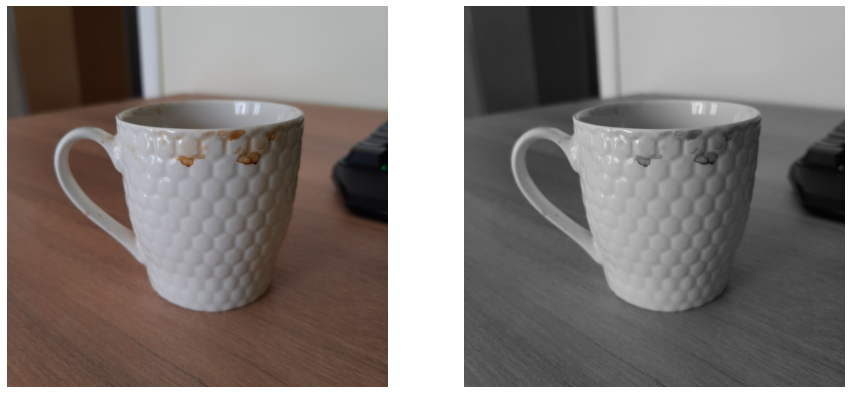

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,15))
ax1.axis('off')
ax2.axis('off')

ax1.imshow(coffee_image)
ax2.imshow(coffee_gray,cmap='gray')

## Keypoints & Descriptors extraction

Let's first create our SIFT features detector by create an instance of it.

In [5]:
sift = cv.SIFT_create()

This method will return the keypoints and the coressponding descriptor for each of the keypoints.

In [6]:
coffee_keypoints, coffee_descriptor = sift.detectAndCompute(coffee_gray,None)

In [7]:
print('Number of keypoints : ',len(coffee_keypoints))
print('{} keypoints of {} descriptors each'.format(coffee_descriptor.shape[0],coffee_descriptor.shape[1]))

Number of keypoints :  374
374 keypoints of 128 descriptors each


So the descriptor is a matrix of $n$ rows representing the number of keypoints, but has 128 columns corresponding to the contatenated histogram.

<center><img src="data\sift\sift_descriptor.png" ></center>

## The Keypoints

Let's look at the first keypoint! 

The ``detectAndCompute()`` method returns an output as follow: 

- keypoints The detected keypoints. A 1-by-N structure array with the following fields:
- pt : coordinates of the keypoint [x,y]
- size : diameter of the meaningful keypoint neighborhood
- angle :  computed orientation of the keypoint (-1 if not applicable); it's in [0,360) degrees and measured relative to image coordinate system (y-axis is directed downward), i.e in clockwise.
- response : the response by which the most strong keypoints have been selected. Can be used for further sorting or subsampling.
- octave : octave (pyramid layer) from which the keypoint has been extracted.
- class_id : object class (if the keypoints need to be clustered by an object they belong to).

In [8]:
print('Point 0')
print('x,y ',coffee_keypoints[0].pt)
print('size:',coffee_keypoints[0].size)
print('angle:',coffee_keypoints[0].angle)
print('response:',coffee_keypoints[0].response)
print('class_id:',coffee_keypoints[0].class_id)

Point 0
x,y  (131.73941040039062, 3297.093017578125)
size: 2.451364278793335
angle: 222.79859924316406
response: 0.016703972592949867
class_id: -1


## The descriptor 

As by the documentation, the descriptor comes as follow : 

*Output concatenated vectors of descriptors. Each descriptor is a 128-element vector, as returned by cv.SIFT.descriptorSize, so the total size of descriptors will be numel(keypoints) * obj.descriptorSize(). A matrix of size N-by-128 of class single, one row per keypoint.*

In [9]:
coffee_descriptor[20]

array([ 25.,  18.,  15.,  11.,   5.,   9.,  23.,  22.,  86.,  76.,   7.,
         1.,   1.,   1.,  11.,  59.,  10.,  22.,   5.,   4.,  90.,  45.,
        20.,  18.,   0.,   0.,   0.,   2., 133.,  42.,   1.,   0.,  60.,
        20.,  28.,  39.,  56.,  18.,   4.,  15., 133.,  71.,  12.,   8.,
         7.,  10.,  58., 133.,  16.,  14.,   6.,  75., 133.,  69.,  80.,
        47.,   0.,   0.,   0.,  28., 131.,  52.,   2.,   1.,  40.,  12.,
         1.,  14.,  27.,  23.,  19.,  14., 133., 133.,  56.,  38.,   6.,
         5.,  11.,  26.,  13.,  51.,  64., 133.,  94.,   8.,   4.,   5.,
         1.,   0.,   1.,  46.,  52.,  15.,   1.,   3.,   1.,   1.,   0.,
         2.,   7.,  25.,  76.,  20.,  18.,  53.,  18.,   5.,  17.,  26.,
        14.,   3.,  12.,  22.,  31.,  28.,   3.,   2.,   4.,  22.,   2.,
         1.,   1.,  20.,  47.,  15.,   5.,   6.], dtype=float32)

Let's plot the histogram of the 8 orientations for some keypoints.

<AxesSubplot:title={'center':'Histogram of Oriented Direction for keypoint 1'}, xlabel='Orientation (degree)', ylabel='Count'>

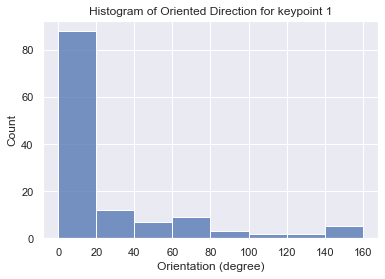

In [10]:
plt.title('Histogram of Oriented Direction for keypoint 1')
plt.xlabel('Orientation (degree)')
sns.histplot(data=coffee_descriptor[300], binwidth=20,bins=8)

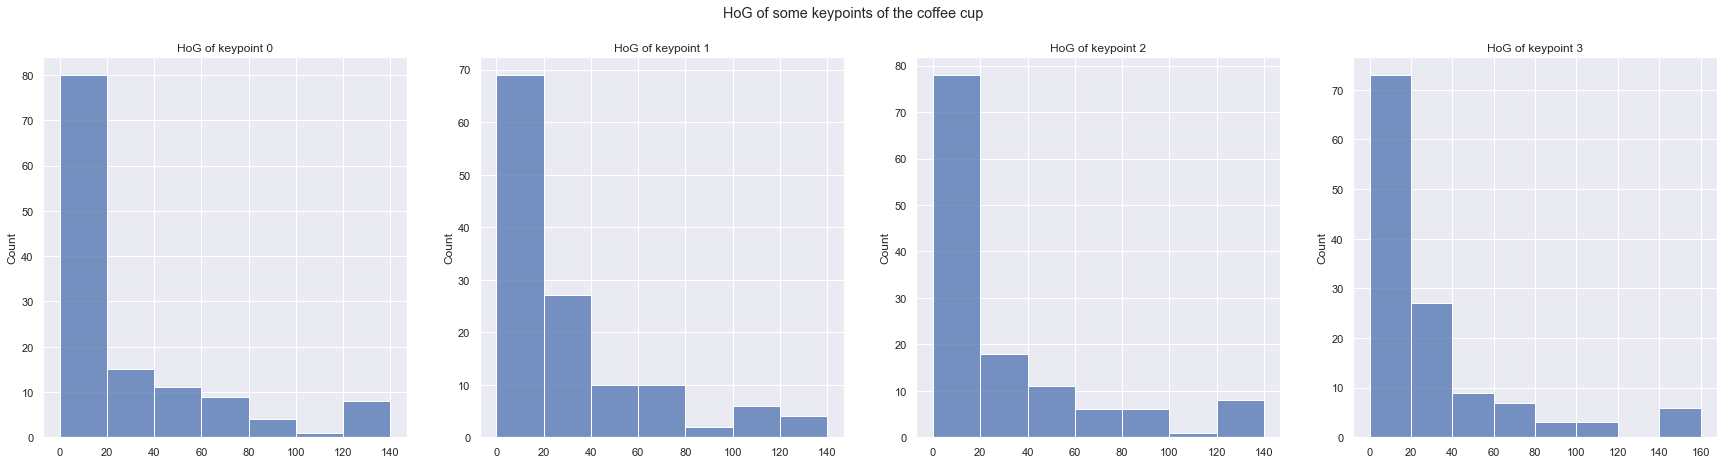

In [11]:
fig, axes = plt.subplots(1, 4,figsize=(30,7))
fig.suptitle('HoG of some keypoints of the coffee cup')
for _,descriptor in enumerate(coffee_descriptor[:axes.size,:]):
  axes[_].set_title('HoG of keypoint {}'.format(_))
  sns.histplot(data=coffee_descriptor[_], binwidth=20,bins=8,ax=axes[_])

## Looking at our keypoints

In [12]:
coffee_features = cv.drawKeypoints(coffee_image, coffee_keypoints,None, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

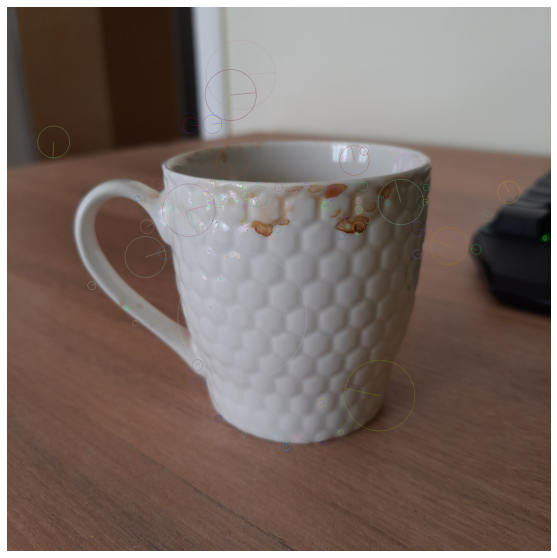

In [13]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(coffee_features)
plt.show()

## Checking the Scale-Rotation Invariance 

We said earlier that SIFT is Scale and Rotational Invariant, let's try this.

Let's take our coffee cup and rotate it.

In [14]:
# grab the dimensions of the image and calculate the center of the image
(h, w) = coffee.shape[:2]
(cX, cY) = (w // 2, h // 2)

In [15]:
# rotate our image by 45 degrees around the center of the image
M = cv.getRotationMatrix2D((cX, cY), 45, 1.0)
rotated = cv.warpAffine(coffee, M, (w, h))

Now let's scale it down.

In [16]:
scale_percent = 20 # percent of original size

width = int(rotated.shape[1] * scale_percent / 100)
height = int(rotated.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized_and_rotated = cv.resize(rotated, dim, interpolation = cv.INTER_AREA)

In [17]:
rotated_gray = cv.cvtColor(resized_and_rotated, cv.COLOR_RGB2GRAY)

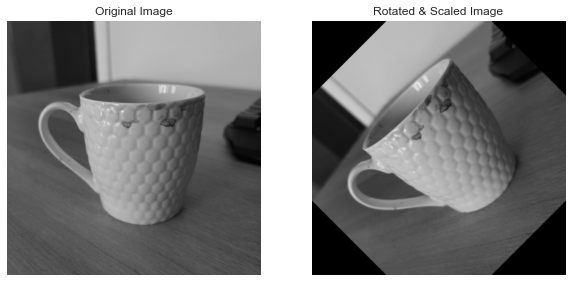

In [18]:
# Display traning image and testing image
fx, plots = plt.subplots(1, 2, figsize=(10,5))
[axi.set_axis_off() for axi in plots.ravel()]

plots[0].set_title("Original Image")
plots[0].imshow(coffee_gray,cmap="gray")

plots[1].set_title("Rotated & Scaled Image")
plots[1].imshow(rotated_gray,cmap="gray")

Now we have 2 images of a coffee cup, one original and one rotated. 

Let's extract the keypoints of the two images and display them.

To see if the SIFT is scale and rotation invariant, let's compute the keypoints of the rotated and scaled coffee cup.

In [19]:
test_keypoints, test_descriptor = sift.detectAndCompute(rotated_gray, None)

In [31]:
print('Number of keypoints : ',len(test_keypoints))
print('{} keypoints of {} descriptors each'.format(test_descriptor.shape[0],test_descriptor.shape[1]))

Number of keypoints :  185
185 keypoints of 128 descriptors each


As expected, there a less keypoints because the image is smaller.

## 🧩Feature Matching

To match SIFT features in one image with others, we use the Brute-Force matcher in OpenCV.

The **Brute-Force Matcher** takes the descriptor of one feature in first set and is matched with all other features in
second set using some distance calculation. The closest one is returned.

From the distance norms calculations :  L1 and L2 norms are preferable choices for SIFT and SURF descriptors.

### 🥊 Brute Force approach 

In [21]:
# Create a Brute Force Matcher object.
bf = cv.BFMatcher(cv.NORM_L2, crossCheck = False)

In [22]:
# Perform the matching between the SIFT descriptors of the training image and the test image
matches = bf.match(coffee_descriptor, test_descriptor)

In [23]:
len(matches)

374

In [25]:
# We took a random match and see what information we have on it
print('Match number 6')
print('Distance between descriptors: ',matches[5].distance)
print('Index of the descriptor in coffee descriptors: ',matches[5].trainIdx)
print('Index of the descriptor in desktop descriptors: ',matches[5].queryIdx) 
print('Index of the train image: ',matches[5].imgIdx)

Match number 6
Distance between descriptors:  392.24481201171875
Index of the descriptor in coffee descriptors:  56
Index of the descriptor in desktop descriptors:  5
Index of the train image:  0


In [26]:
# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

In [32]:
# # Draw first 10 matches
result = cv.drawMatches(coffee_gray, coffee_keypoints, rotated_gray, test_keypoints, matches[:20],None, flags = 2)

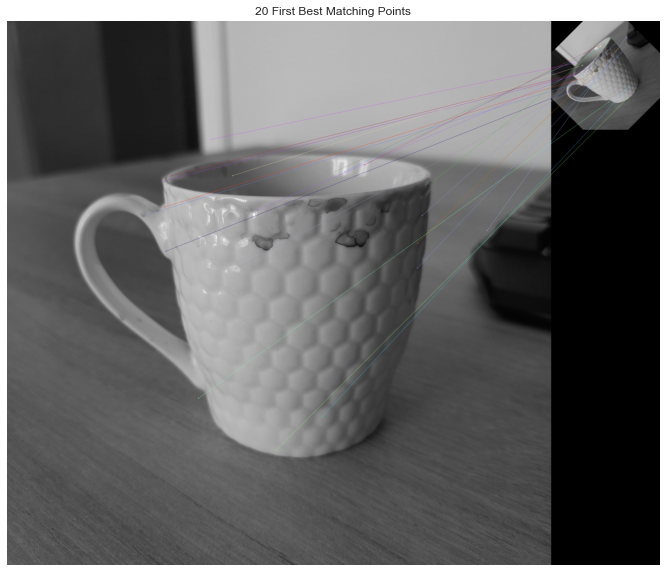

In [33]:
# Display the best matching points
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('20 First Best Matching Points')
plt.imshow(result)
plt.show()

### 🏡 K-nearest Neighbors Matcher

This time, we will use ``BFMatcher.knnMatch()`` to get $k$ best matches. In this example, we will take $k=2$ so that we can apply ratio test explained by D.Lowe in his paper.

David Lowe proposed a simple method for filtering keypoint matches by eliminating matches when the second-best match is almost as good.

*[...] One reason the BBF algorithm works particularly well for this problem is that we only consider matches in which the nearest neighbor is less than 0.8 times the distance to the second-nearest neighbor (D. Lowe, paper)*

In [34]:
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(coffee_descriptor,test_descriptor, k=2)

In [35]:
# Apply ratio test
good_features = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_features.append([m])

In [36]:
# # Draw only the good features
result = cv.drawMatchesKnn(coffee_gray, coffee_keypoints, rotated_gray, test_keypoints, good_features,None, flags = 2)

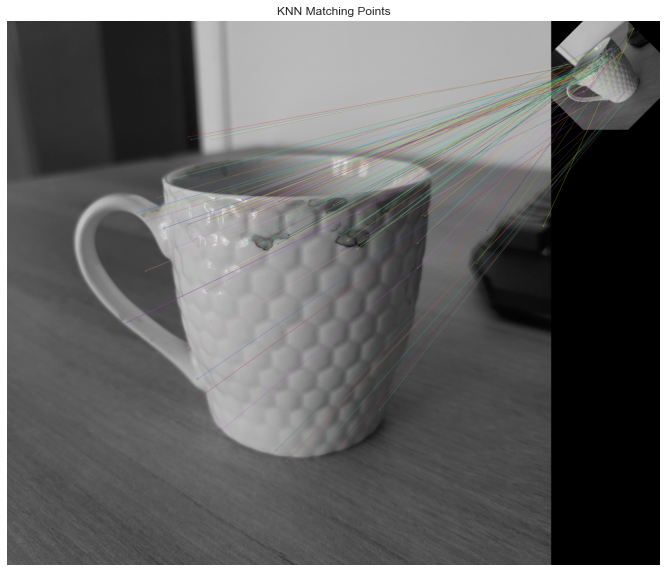

In [37]:
# Display the best matching points
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('KNN Matching Points')
plt.imshow(result)
plt.show()

# ☕ Object recognition using SIFT features

Given SIFT's ability to find distinctive keypoints that are invariant to location, scale and rotation, and robust to affine transformations (changes in scale, rotation, shear, and position) and changes in illumination, they are usable for object recognition. The steps are given below.

I have taken an image of my desktop with my coffee cup, using SIFT, I'm going to try to detect the cup of coffee on my desktop.


In [38]:
# Load the image
desktop = cv.imread('data\sift\desktop_coffee.jpg')

# Convert the training image to RGB
desktop_image = cv.cvtColor(desktop, cv.COLOR_BGR2RGB)

# Convert the training image to gray scale
desktop_gray = cv.cvtColor(desktop_image, cv.COLOR_RGB2GRAY)

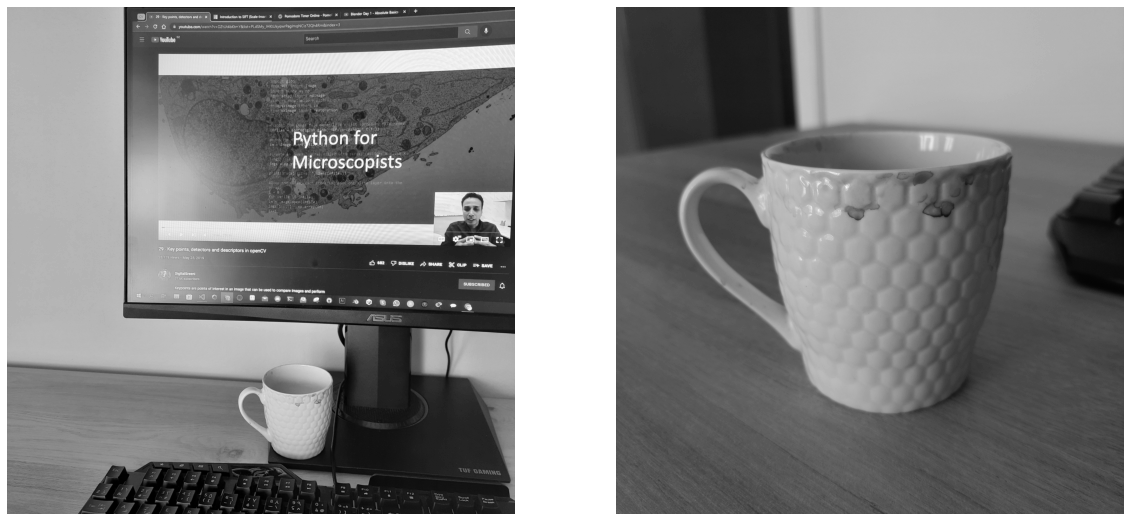

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,20))
ax1.axis('off')
ax2.axis('off')

ax1.imshow(desktop_gray,cmap='gray')
ax2.imshow(coffee_gray,cmap='gray')

Since I already computed the keypoints of the cup of coffee, I'm going to do it for the desktop.

In [40]:
desktop_keypoints, desktop_descriptor = sift.detectAndCompute(desktop_gray, None)

<h4>Drawing the keypoints onto the images</h4>

In [41]:
desktop_features = cv.drawKeypoints(desktop_image, desktop_keypoints, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

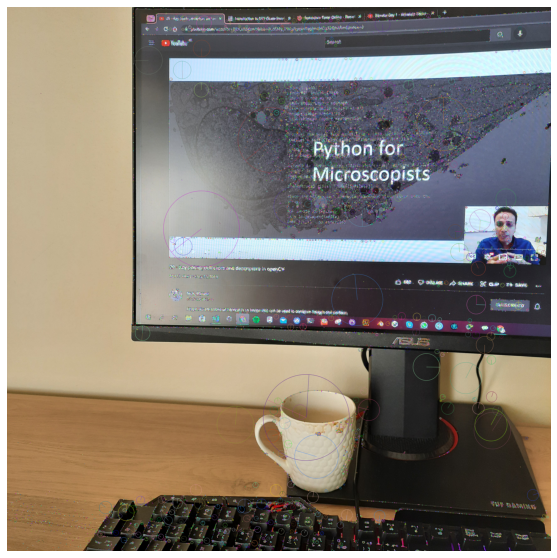

In [42]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(desktop_features)
plt.show()

In [43]:
# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(coffee_descriptor,desktop_descriptor, k=2)

Here, we choose the best matches.

In [101]:
# Apply ratio test
good_features = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_features.append([m])

In [102]:
# # Draw only the good features
comparaison = cv.drawMatchesKnn(coffee_image, coffee_keypoints, desktop_image, desktop_keypoints, good_features,None, flags = 2)

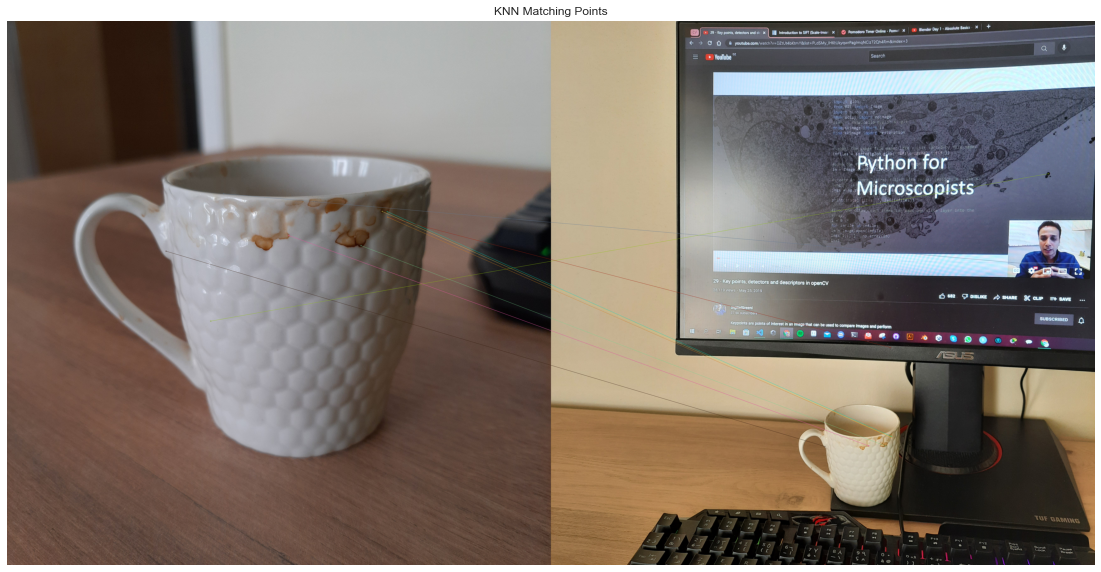

In [103]:
# Display the best matching points
plt.figure(figsize=(20,10))
plt.axis('off')
plt.title('KNN Matching Points')
plt.imshow(comparaison)
plt.show()

It worked! Our coffee cup was found.

# 📚 References
1. *Lecture 05 - Scale-invariant Feature Transform (SIFT)*,https://youtu.be/NPcMS49V5hg
2. *Introduction to SIFT( Scale Invariant Feature Transform)*, https://medium.com/data-breach/introduction-to-sift-scale-invariant-feature-transform-65d7f3a72d40
3. *SIFT Interest Point Detector Using Python*, https://www.geeksforgeeks.org/sift-interest-point-detector-using-python-opencv/
4. *SIFT, OpenCV official documentation*,https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
5. *mexopencv, Documentation for Matlab and Python*, https://amroamroamro.github.io/mexopencv/matlab/cv.SIFT.detectAndCompute.html
6. *Distinctive Image Features from Scale-Invariant Keypoints, David G. Lowe*, https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf
7. *Scale-invariant feature transform*, https://en.wikipedia.org/wiki/Scale-invariant_feature_transform
8. *Theory of edge detection*, http://www.hms.harvard.edu/bss/neuro/bornlab/qmbc/beta/day4/marr-hildreth-edge-prsl1980.pdf